In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, RMSprop
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook

# Dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Preprocessing

X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [ ]:
# Set the dimensions of the noise
z_dim = 100

In [ ]:
# Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

g = Sequential()
g.add(Dense(256, input_dim=z_dim, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(1024, activation=LeakyReLU(alpha=0.2)))
g.add(Dense(784, activation='sigmoid'))  # Values between 0 and 1
g.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d = Sequential()
d.add(Dense(1024, input_dim=784, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(512, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(256, activation=LeakyReLU(alpha=0.2)))
d.add(Dropout(0.3))
d.add(Dense(1, activation='sigmoid'))  # Values between 0 and 1
d.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

d.trainable = False
inputs = Input(shape=(z_dim, ))
hidden = g(inputs)
output = d(hidden)
gan = Model(inputs, output)
gan.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.6/dist-packages/keras/activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [ ]:
def plot_loss(losses):
    """
    @losses.keys():
        0: loss
        1: accuracy
    """
    d_loss = [v[0] for v in losses["D"]]
    g_loss = [v[0] for v in losses["G"]]
#     d_acc = [v[1] for v in losses["D"]]
#     g_acc = [v[1] for v in losses["G"]]
    
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
#     plt.plot(d_acc, label="Discriminator accuracy")
#     plt.plot(g_acc, label="Generator accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
def plot_generated(n_ex=10, dim=(1, 10), figsize=(12, 2)):
    noise = np.random.normal(0, 1, size=(n_ex, z_dim))
    generated_images = g.predict(noise)
    generated_images = generated_images.reshape(n_ex, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# Set up a vector (dict) to store the losses
losses = {"D":[], "G":[]}

def train(epochs=1, plt_frq=1, BATCH_SIZE=128):
    batchCount = int(X_train.shape[0] / BATCH_SIZE)
    print('Epochs:', epochs)
    print('Batch size:', BATCH_SIZE)
    print('Batches per epoch:', batchCount)
    
    for e in tqdm_notebook(range(1, epochs+1)):
        if e == 1 or e%plt_frq == 0:
            print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in range(batchCount):  # tqdm_notebook(range(batchCount), leave=False):
            # Create a batch by drawing random index numbers from the training set
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)]
            # Create noise vectors for the generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            
            # Generate the images from the noise
            generated_images = g.predict(noise)
            X = np.concatenate((image_batch, generated_images))
            # Create labels
            y = np.zeros(2*BATCH_SIZE)
            y[:BATCH_SIZE] = 0.9  # One-sided label smoothing

            # Train discriminator on generated images
            d.trainable = True
            d_loss = d.train_on_batch(X, y)

            # Train generator
            noise = np.random.normal(0, 1, size=(BATCH_SIZE, z_dim))
            y2 = np.ones(BATCH_SIZE)
            d.trainable = False
            g_loss = gan.train_on_batch(noise, y2)

        # Only store losses from final batch of epoch
        losses["D"].append(d_loss)
        losses["G"].append(g_loss)

        # Update the plots
        if e == 1 or e%plt_frq == 0:
            plot_generated()
    plot_loss(losses)

Epochs: 200
Batch size: 128
Batches per epoch: 468


--------------- Epoch 1 ---------------
Instructions for updating:
Use tf.cast instead.


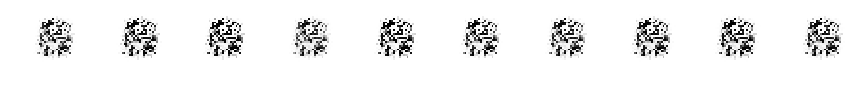

--------------- Epoch 10 ---------------


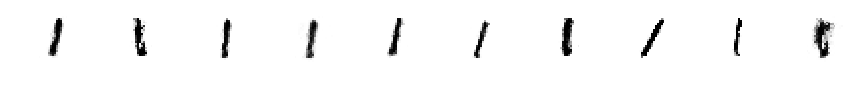

--------------- Epoch 20 ---------------


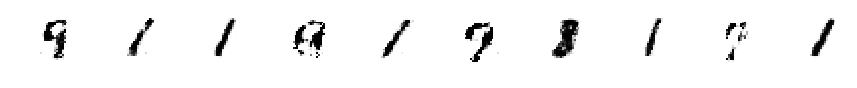

--------------- Epoch 30 ---------------


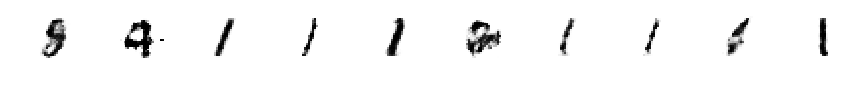

--------------- Epoch 40 ---------------


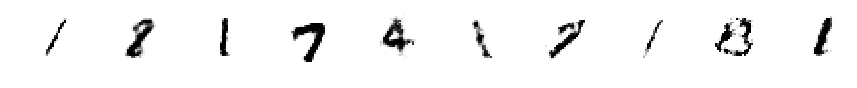

--------------- Epoch 50 ---------------


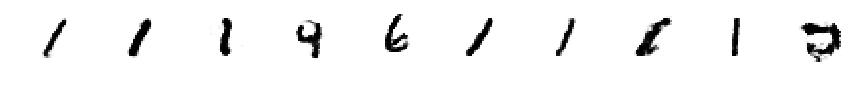

--------------- Epoch 60 ---------------


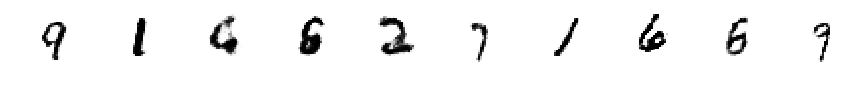

--------------- Epoch 70 ---------------


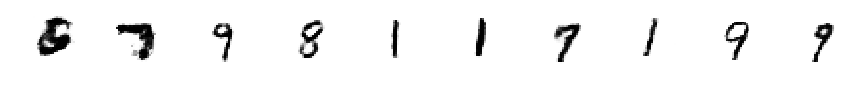

--------------- Epoch 80 ---------------


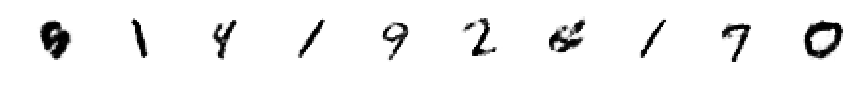

--------------- Epoch 90 ---------------


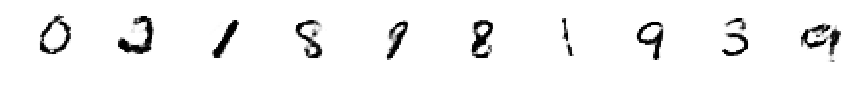

--------------- Epoch 100 ---------------


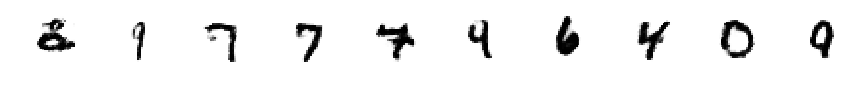

--------------- Epoch 110 ---------------


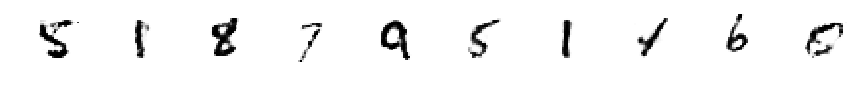

--------------- Epoch 120 ---------------


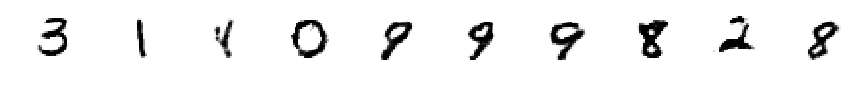

--------------- Epoch 130 ---------------


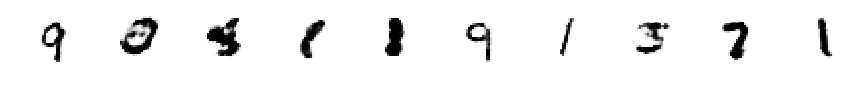

--------------- Epoch 140 ---------------


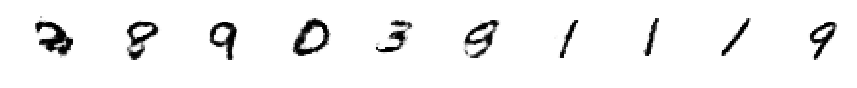

--------------- Epoch 150 ---------------


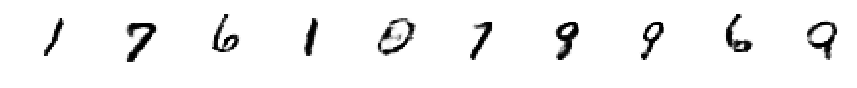

--------------- Epoch 160 ---------------


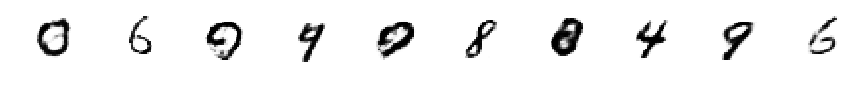

--------------- Epoch 170 ---------------


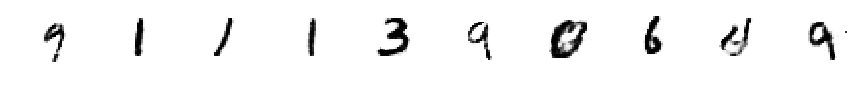

--------------- Epoch 180 ---------------


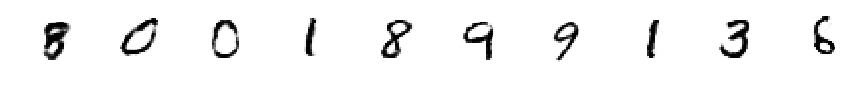

--------------- Epoch 190 ---------------


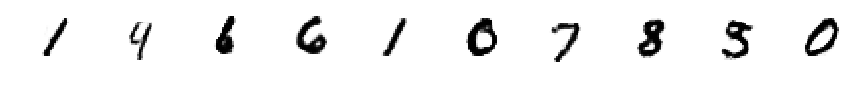

--------------- Epoch 200 ---------------


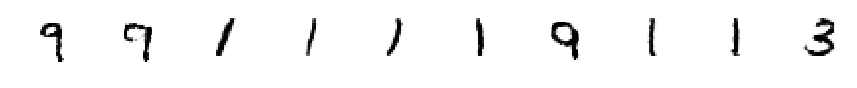

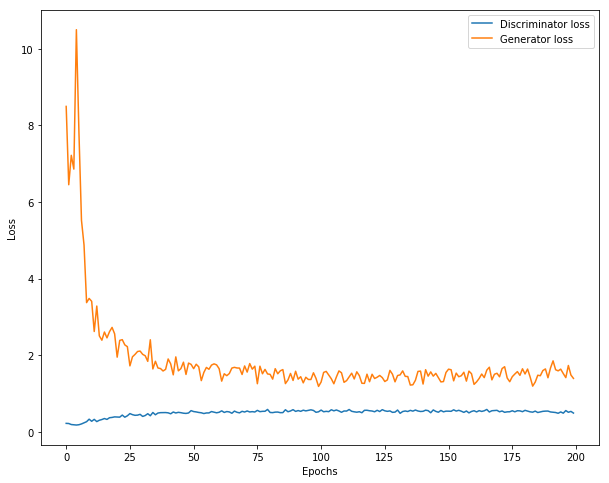

In [ ]:
train(epochs=200, plt_frq=10, BATCH_SIZE=128)

In [ ]:
# Generator

generator = Model(inputs,hidden)

test = np.random.normal(0, 1, size=(100, z_dim))
test.shape

(100, 100)

In [ ]:
generated_image = generator.predict(test)
generated_image.shape

(100, 784)

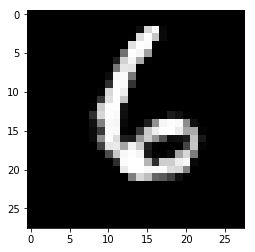

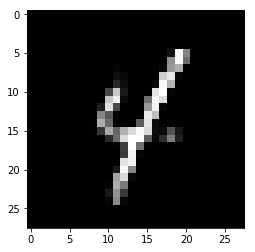

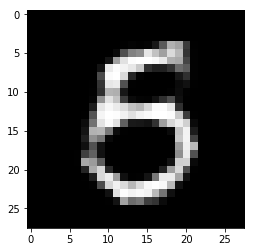

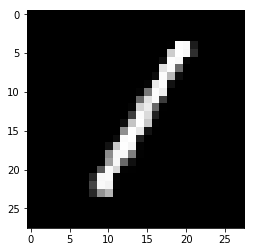

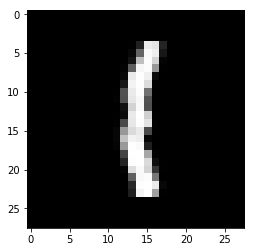

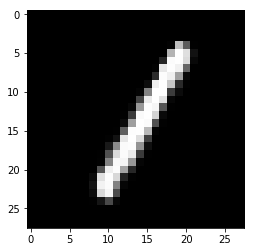

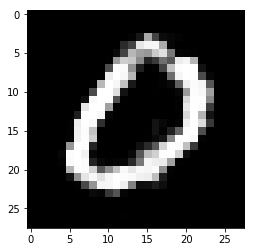

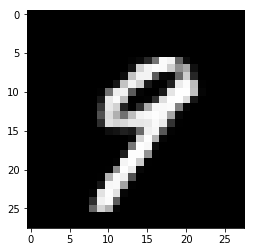

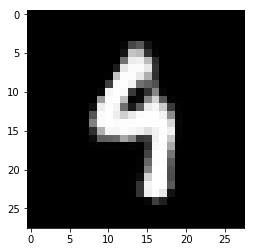

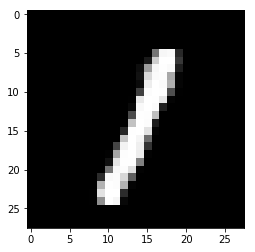

In [ ]:
for i in range(10):
  plt.imshow(generated_image[i].reshape(28,28),cmap='gray')
  plt.show()

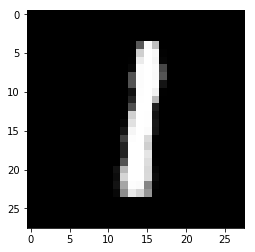

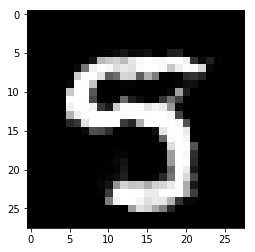

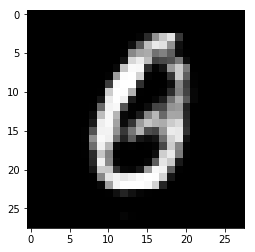

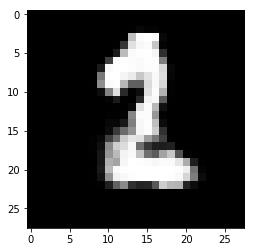

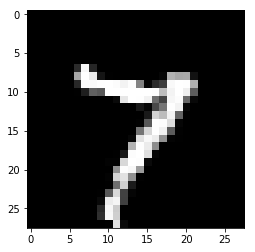

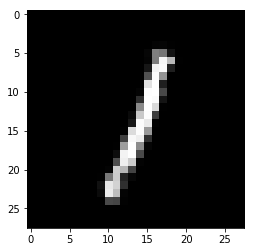

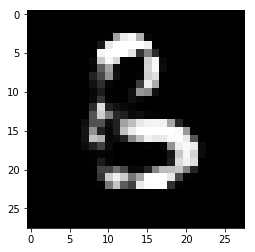

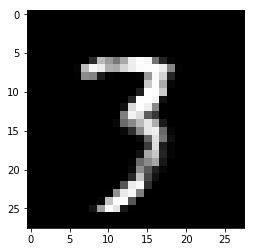

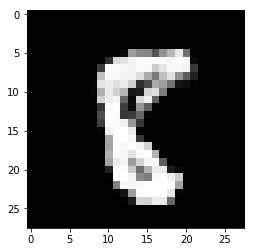

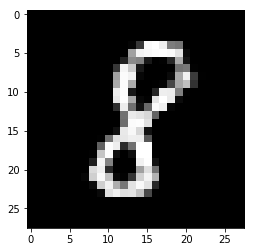

In [ ]:
for i in range(80,90):
  plt.imshow(generated_image[i].reshape(28,28),cmap='gray')
  plt.show()

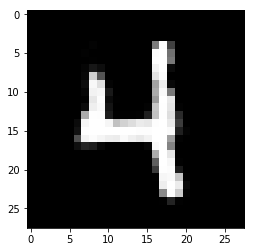

In [ ]:
plt.imshow(generated_image[57].reshape(28,28),cmap='gray')
plt.show()

In [ ]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
image_batch = X_train[np.random.randint(0, X_train.shape[0], size=468)]

In [ ]:
print(losses)

{'D': [[0.21825062, 0.5], [0.21444708, 0.5], [0.1878153, 0.5], [0.18071102, 0.5], [0.17476343, 0.5], [0.18276675, 0.5], [0.20337428, 0.5], [0.23130053, 0.5], [0.2620439, 0.5], [0.32754123, 0.5], [0.27263954, 0.5], [0.32294282, 0.5], [0.26470226, 0.5], [0.299429, 0.5], [0.3183221, 0.5], [0.344459, 0.4921875], [0.3217852, 0.4921875], [0.3657889, 0.48828125], [0.3735177, 0.4765625], [0.38764668, 0.484375], [0.38393223, 0.5], [0.38043952, 0.48046875], [0.43456596, 0.44921875], [0.37925175, 0.4765625], [0.4159305, 0.46875], [0.47374302, 0.46875], [0.44558, 0.48046875], [0.4287009, 0.453125], [0.43345323, 0.4453125], [0.45401946, 0.4375], [0.39924806, 0.47265625], [0.4231972, 0.45703125], [0.47041103, 0.4453125], [0.41679624, 0.4453125], [0.50249285, 0.42578125], [0.44271103, 0.484375], [0.4879495, 0.44140625], [0.4979324, 0.4453125], [0.49966207, 0.4609375], [0.5003994, 0.4453125], [0.49336332, 0.44921875], [0.46808764, 0.4375], [0.51475006, 0.44140625], [0.48945904, 0.41015625], [0.5061934